In [17]:
import os
import random
import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import ImageOps
from keras import models, regularizers, optimizers, losses
from keras.layers import Conv2D, SeparableConv2D, Conv2DTranspose, MaxPool2D, UpSampling2D, Dropout, Dense, Flatten, Input, BatchNormalization, add
from keras.utils import to_categorical
from keras.src.utils import load_img
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io
from sklearn import metrics

Based on https://keras.io/examples/vision/oxford_pets_image_segmentation/

In [19]:
def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Returns a TF Dataset."""

    def load_img_masks(input_img_path, target_img_path):
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.resize(input_img, img_size)
        input_img = tf_image.convert_image_dtype(input_img, "float32")

        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        target_img = tf_image.resize(target_img, img_size, method="nearest")
        target_img = tf_image.convert_image_dtype(target_img, "uint8")

        # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
        target_img -= 1
        return input_img, target_img

    # For faster debugging, limit the size of data
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)

In [20]:
input_dir = os.getcwd() + "/datasets/segmentation/images/"
target_dir = os.getcwd() + "/datasets/segmentation/annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
C:\Users\lenovo\OneDrive\Pulpit\Python\Neural-Networks/datasets/segmentation/images/Abyssinian_1.jpg | C:\Users\lenovo\OneDrive\Pulpit\Python\Neural-Networks/datasets/segmentation/annotations/trimaps/Abyssinian_1.png
C:\Users\lenovo\OneDrive\Pulpit\Python\Neural-Networks/datasets/segmentation/images/Abyssinian_10.jpg | C:\Users\lenovo\OneDrive\Pulpit\Python\Neural-Networks/datasets/segmentation/annotations/trimaps/Abyssinian_10.png
C:\Users\lenovo\OneDrive\Pulpit\Python\Neural-Networks/datasets/segmentation/images/Abyssinian_100.jpg | C:\Users\lenovo\OneDrive\Pulpit\Python\Neural-Networks/datasets/segmentation/annotations/trimaps/Abyssinian_100.png
C:\Users\lenovo\OneDrive\Pulpit\Python\Neural-Networks/datasets/segmentation/images/Abyssinian_101.jpg | C:\Users\lenovo\OneDrive\Pulpit\Python\Neural-Networks/datasets/segmentation/annotations/trimaps/Abyssinian_101.png
C:\Users\lenovo\OneDrive\Pulpit\Python\Neural-Networks/datasets/segmentation/images/Abyssinian_102

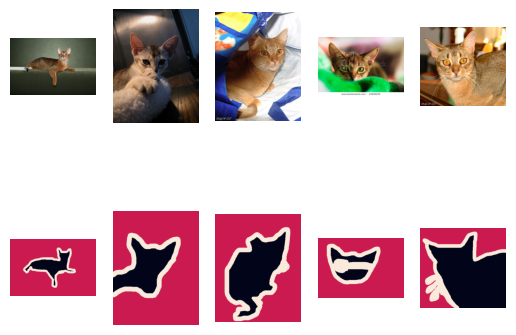

In [21]:
i = 0
plt.figure()
for path_in, path_tar in zip(input_img_paths, target_img_paths):
    plt.subplot(2, 5, i+1)
    plt.imshow(plt.imread(path_in))
    plt.axis('off')

    plt.subplot(2, 5, 5+i+1)
    plt.imshow(plt.imread(path_tar))
    plt.axis('off')

    i += 1

    if i == 5:
        break


In [22]:
inputs = Input(shape=img_size + (3,))
x = Conv2D(32, 3, strides=2, padding="same", activation="relu")(inputs)
x = BatchNormalization()(x)
prev = x

for filters in (64, 128, 256):
    x = SeparableConv2D(filters, 3, padding="same", activation="relu")(x)
    x = BatchNormalization()(x)

    x = SeparableConv2D(filters, 3, padding="same", activation="relu")(x)
    x = BatchNormalization()(x)

    x = MaxPool2D(3, strides=2, padding="same")(x)

    residual = Conv2D(filters, 1, strides=2, padding="same")(prev)
    x = add([x, residual])
    prev = x

for filters in (256, 128, 64, 32):
    x = Conv2DTranspose(filters, 3, padding="same", activation="relu")(x)
    x = BatchNormalization()(x)

    x = Conv2DTranspose(filters, 3, padding="same", activation="relu")(x)
    x = BatchNormalization()(x)

    x = UpSampling2D(2)(x)

    residual = UpSampling2D(2)(prev)
    residual = Conv2D(filters, 1, padding="same")(residual)
    x = add([x, residual])
    prev = x

outputs = Conv2D(3, 3, activation="softmax", padding="same")(x)

model = keras.Model(inputs, outputs)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 80, 80,    │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        128 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_6  │ (None, 80, 80,    │      2,400 │ batch_normalizat… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_7  │ (None, 80, 80,    │      4,736 │ batch_normalizat… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 40, 40,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 40, 40,    │      2,112 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 40, 40,    │          0 │ max_pooling2d_3[… │
│                     │ 64)               │            │ conv2d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_8  │ (None, 40, 40,    │      8,896 │ add_7[0][0]       │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 40,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_9  │ (None, 40, 40,    │     17,664 │ batch_normalizat… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 40,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 20, 20,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 20, 20,    │      8,320 │ add_7[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 20, 20,    │          0 │ max_pooling2d_4[

 Total params: 2,058,979 (7.85 MB)

 Trainable params: 2,055,203 (7.84 MB)

 Non-trainable params: 3,776 (14.75 KB)

In [23]:
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

train_dataset = get_dataset(
    batch_size,
    img_size,
    train_input_img_paths,
    train_target_img_paths,
    max_dataset_len=1000,
)
valid_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)

In [24]:
epochs = 40
batch_size = 128
opt = optimizers.Adam(0.001)
loss = losses.sparse_categorical_crossentropy

model.compile(loss=loss,
              optimizer=opt,
              metrics=['acc'])

In [25]:
history = model.fit(train_dataset,
          # batch_size=batch_size,
          epochs=epochs,
          validation_data = valid_dataset,
          verbose=1)

Epoch 1/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - acc: 0.6087 - loss: 1.9937 - val_acc: 0.4018 - val_loss: 1.2588
Epoch 2/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - acc: 0.7200 - loss: 0.7062 - val_acc: 0.5820 - val_loss: 1.4718
Epoch 3/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - acc: 0.7498 - loss: 0.6239 - val_acc: 0.5839 - val_loss: 2.1081
Epoch 4/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - acc: 0.7705 - loss: 0.5724 - val_acc: 0.5840 - val_loss: 2.8399
Epoch 5/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - acc: 0.7905 - loss: 0.5244 - val_acc: 0.5840 - val_loss: 3.4106
Epoch 6/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - acc: 0.8085 - loss: 0.4797 - val_acc: 0.5840 - val_loss: 4.2982
Epoch 7/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - acc: 0.8238 - loss: 0.4412 - val_acc: 0.5840 - val_loss: 5.5094
Epoch 8/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - acc: 0.8167 - loss: 0.4597 - val_acc: 0.5840 - val_loss: 5.7269
Epoch 9/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - acc: 0.8264 - loss: 

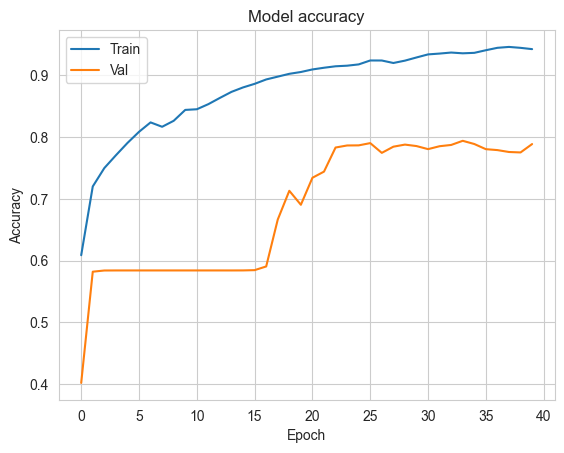

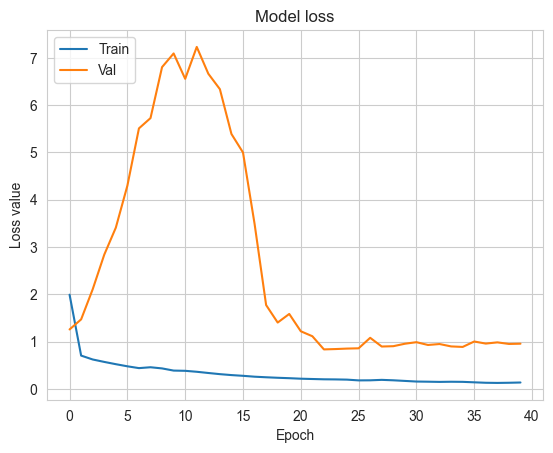

In [26]:
acc = history.history['acc']
loss = history.history['loss']

val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.figure()
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 279ms/step - acc: 0.7887 - loss: 0.9575
Test loss: 0.9574961066246033
Test accuracy: 0.7887133955955505


C:\Users\lenovo\OneDrive\Pulpit\Python\Neural-Networks\venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


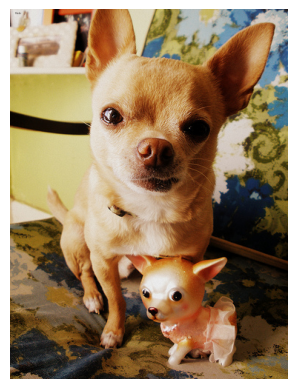

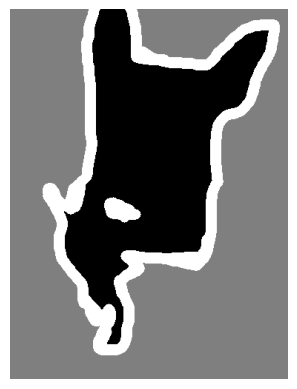

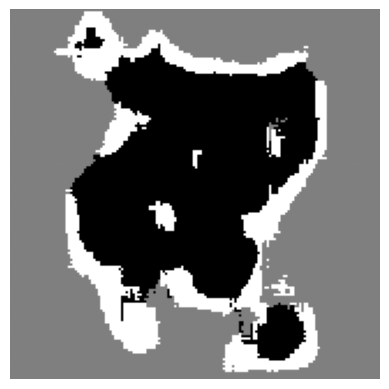

In [27]:
val_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)
val_preds = model.predict(val_dataset)
score = model.evaluate(val_dataset, steps=50)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

sample = random.randint(0, 1000)

plt.imshow(plt.imread(val_input_img_paths[sample]))
plt.axis('off')
plt.show()

img = ImageOps.autocontrast(load_img(val_target_img_paths[sample]))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

mask = np.argmax(val_preds[sample], axis=-1)
mask = np.expand_dims(mask, axis=-1)
img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()